In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import f_oneway, uniform

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics.pairwise import kernel_metrics, chi2_kernel
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

`sklearn.metrics.pairwise.kernel_metrics()` to list available kernels

In [2]:
kernel_metrics()

{'additive_chi2': <function sklearn.metrics.pairwise.additive_chi2_kernel(X, Y=None)>,
 'chi2': <function sklearn.metrics.pairwise.chi2_kernel(X, Y=None, gamma=1.0)>,
 'linear': <function sklearn.metrics.pairwise.linear_kernel(X, Y=None, dense_output=True)>,
 'polynomial': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'poly': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'rbf': <function sklearn.metrics.pairwise.rbf_kernel(X, Y=None, gamma=None)>,
 'laplacian': <function sklearn.metrics.pairwise.laplacian_kernel(X, Y=None, gamma=None)>,
 'sigmoid': <function sklearn.metrics.pairwise.sigmoid_kernel(X, Y=None, gamma=None, coef0=1)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True)>}

Each of these are interesting in their own ways, but the most applicable to our case will be `additive_chi2` and `chi2`, `linear`, `rbf` and `laplacian`. We will do trials of each, but `rbf` will be approximated using the `sklearn.kernel_approximation.Nystroem` method since it is intractable with so many samples especially if we need to enable probability prediction.

## Data Read

In [3]:
#d_full = pd.read_csv('../data/d_full.csv')

d_sub = pd.read_csv('../data/d_sub.csv')

x, y = *(d_sub.drop('label', axis=1),
         d_sub['label']),

x, y = map(lambda j: j.to_numpy(), (x,y))

## SGD Initialization

In [4]:
sgd = SGDClassifier(loss='log',
                    penalty='l1',
                    #early_stopping=True,
                    class_weight='balanced',
                    n_jobs=-1)

## Example Nystroem Approximation

In [5]:
chi2_approx = Nystroem(kernel='rbf').fit_transform(x, y)
chi2_approx

array([[0.11451708, 0.08217092, 0.11872506, ..., 0.08559195, 0.09962076,
        0.11384289],
       [0.11983949, 0.08751207, 0.11734879, ..., 0.08650443, 0.10076226,
        0.11959003],
       [0.1085166 , 0.08113089, 0.11624793, ..., 0.08114507, 0.1026565 ,
        0.10776122],
       ...,
       [0.11992528, 0.07454495, 0.0950647 , ..., 0.07263699, 0.08445363,
        0.11384676],
       [0.1187278 , 0.07292577, 0.09770222, ..., 0.07517644, 0.08422444,
        0.11301359],
       [0.11969643, 0.08432306, 0.12407968, ..., 0.09356894, 0.09749928,
        0.12015452]])

In [6]:
scores = cross_val_score(sgd, chi2_approx, y, scoring='precision_micro', cv=5)
scores

array([0.70991768, 0.59427675, 0.56722854, 0.60329283, 0.56509804])

In [7]:
scores = cross_val_score(sgd, chi2_approx, y, scoring='recall_micro', cv=5)
scores

array([0.70168561, 0.59074873, 0.58447668, 0.64131713, 0.56352941])

In [8]:
def train(clf, x, y, kernel='rbf', scoring=None, folds=5, verbose=0, **kwargs):
    approx = Nystroem(kernel=kernel, kernel_params=dict(**kwargs)).fit_transform(x, y)
    return cross_val_score(clf,
                           approx, y,
                           scoring=scoring,
                           cv=StratifiedKFold(n_splits=folds, shuffle=True),
                           verbose=verbose, n_jobs=-1)

## Trials

In [9]:
#np.set_printoptions(precision=2)
sgd = SGDClassifier(loss='log',
                    penalty='l1',
                    #early_stopping=True,
                    #class_weight='balanced',
                    n_jobs=-1, warm_start=False)
kernels_to_try = ('additive_chi2', 'chi2', 'linear', 'rbf', 'laplacian')
scoring = 'recall_weighted'
folds=10
df = {}
for kernel in kernels_to_try:
    scores = train(sgd,
                   x, y,
                   folds=folds,
                   kernel=kernel,
                   scoring=scoring)
    df[kernel] = scores
    print(kernel, ' done...')
f_result = f_oneway(*df.values())
df = pd.DataFrame(df)
df

additive_chi2  done...
chi2  done...
linear  done...
rbf  done...
laplacian  done...


,additive_chi2,chi2,linear,rbf,laplacian
0,0.643417,0.669279,0.652038,0.633229,0.666928
1,0.659091,0.684169,0.637931,0.655956,0.670846
2,0.654389,0.680251,0.619906,0.655956,0.670063
3,0.639498,0.675549,0.619122,0.647335,0.666144
4,0.627451,0.665098,0.639216,0.643137,0.669020
5,0.647059,0.676863,0.641569,0.633725,0.676078
6,0.651765,0.688627,0.632157,0.662745,0.656471
7,0.655686,0.687843,0.632941,0.658824,0.658039
8,0.668235,0.692549,0.649412,0.655686,0.647843
9,0.672157,0.676078,0.640000,0.648627,0.661176


In [10]:
df.mean()

additive_chi2    0.651875
chi2             0.679631
linear           0.636429
rbf              0.649522
laplacian        0.664261
dtype: float64

In [11]:
f_result

F_onewayResult(statistic=24.401218164596045, pvalue=8.792273486175073e-11)

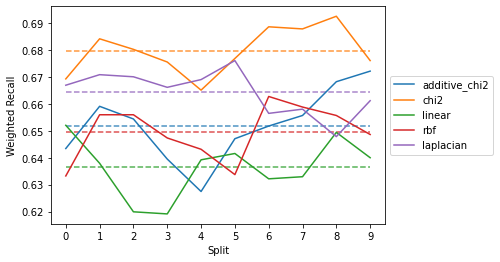

In [12]:
ax = df.plot(use_index=True, xticks=range(folds))
ax.hlines(df.mean(),
          xmin=0, xmax=folds-1,
          linestyles='dashed', alpha=0.8, colors=['C'+str(i) for i in range(5)])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.xlabel('Split');
plt.ylabel('Weighted Recall');

$\chi^2$ does best on average across several runs, so we will use it as our real kernel. We will also calculate the true feature map instead of approximating it using the Nystroem method.

In [48]:
param_grid = {'loss': ('hinge', 'log'),
              'penalty': ('l2', 'l1'),
              #'learning_rate': ('optimal', 'invscaling', 'adaptive'),
              #'power_t': np.logspace(-3, -1, num=10),
              'class_weight': ('balanced', None)
             }

In [51]:
fm = Nystroem(kernel='chi2', n_components=300).fit_transform(x, y)

grid = GridSearchCV(estimator=SGDClassifier(average=True),
                    cv=10, scoring='recall_weighted',
                    param_grid=param_grid,
                    verbose=3, n_jobs=-1)
grid.fit(fm, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   29.9s finished


GridSearchCV(cv=10, estimator=SGDClassifier(average=True), n_jobs=-1,
             param_grid={'class_weight': ('balanced', None),
                         'loss': ('hinge', 'log'), 'penalty': ('l2', 'l1')},
             scoring='recall_weighted', verbose=3)

In [52]:
grid_df = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_loss,param_penalty,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,1.768799,0.075373,0.003201,0.000400,None,log,l2,"{'class_weight': None, 'loss': 'log', 'penalty...",0.623041,0.737461,...,0.578370,0.597647,0.609412,0.626667,0.650196,0.590588,0.600784,0.627639,0.044205,1
4,2.300399,0.131826,0.003600,0.000663,None,hinge,l2,"{'class_weight': None, 'loss': 'hinge', 'penal...",0.631661,0.719436,...,0.588558,0.588235,0.610196,0.631373,0.636863,0.583529,0.605490,0.625286,0.038987,2
2,2.165200,0.184479,0.003201,0.000400,balanced,log,l2,"{'class_weight': 'balanced', 'loss': 'log', 'p...",0.656740,0.774295,...,0.624608,0.568627,0.593725,0.572549,0.625882,0.560000,0.565490,0.622060,0.063848,3
0,2.871202,0.313236,0.003700,0.000641,balanced,hinge,l2,"{'class_weight': 'balanced', 'loss': 'hinge', ...",0.661442,0.769592,...,0.637147,0.563137,0.594510,0.574118,0.626667,0.549804,0.565490,0.621667,0.064259,4
1,3.887799,0.248193,0.003901,0.001513,balanced,hinge,l1,"{'class_weight': 'balanced', 'loss': 'hinge', ...",0.315831,0.188088,...,0.342476,0.176471,0.260392,0.231373,0.198431,0.047059,0.196863,0.215604,0.077468,5
7,2.715232,0.383832,0.002700,0.000900,None,log,l1,"{'class_weight': None, 'loss': 'log', 'penalty...",0.251567,0.212382,...,0.133229,0.221961,0.178039,0.065882,0.108235,0.152941,0.218824,0.177504,0.057597,6
5,3.294600,0.149956,0.003801,0.001166,None,hinge,l1,"{'class_weight': None, 'loss': 'hinge', 'penal...",0.148119,0.084639,...,0.227273,0.190588,0.322353,0.194510,0.137255,0.053333,0.114510,0.172493,0.077307,7
3,3.950401,0.352128,0.004201,0.002785,balanced,log,l1,"{'class_weight': 'balanced', 'loss': 'log', 'p...",0.271944,0.242163,...,0.098746,0.107451,0.159216,0.067451,0.102745,0.067451,0.176471,0.148329,0.067819,8
